In [22]:
### Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [34]:
### Reading the data
pd.set_option('display.max_colwidth', -1)
df =pd.read_csv("sms.tsv",header=None,sep="\t",names=['label','message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [36]:
# Extract stop words
stop = set(stopwords.words("english"))

# Remove punctuation marks
exclude = set(string.punctuation)
ps = PorterStemmer()
corpus = []
def clean_data(data):
    #data['label'] = data['label'].astype("category")
    ## Remove number and punctuation
    for i in range(0 ,len(data)):
        review = re.sub('[^a-zA-Z]', ' ', data['message'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if not word in stop]
        review = ' '.join(review)
        corpus.append(review)
        
#def vectorizer(corpus):
 #   vectorizer = TfidfVectorizer(analyzer = 'word')
 #   return vectorizer.fit_transform(corpus).toarray()
    

clean_data(df)

## TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(corpus)
X = vectorizer.transform(corpus).toarray()
#X = vectorizer(corpus)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [37]:
### One hot encoding for dependent variable
df['label'] = df['label'].astype("category")
spam = pd.get_dummies(df['label'],drop_first=True,prefix='Spam') ### 0-ham,1-spam
df = pd.concat([spam,df],axis=1)
df.drop('label',axis=1,inplace=True)
### Independent  and dependent variable
X = X
Y = df['Spam_spam']


In [11]:
#### Sampling
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
print("The shape of training data : {}".format(x_train.shape))
print("The shape of test data: {}".format(x_test.shape))

The shape of training data : (4457, 6296)
The shape of test data: (1115, 6296)


### Modelling

###### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(solver="lbfgs")
model_LR.fit(x_train,y_train)

### Prediction 
pred_LR = model_LR.predict(x_test)

Confusion matrix, without normalization
[[112  37]
 [  0 966]]


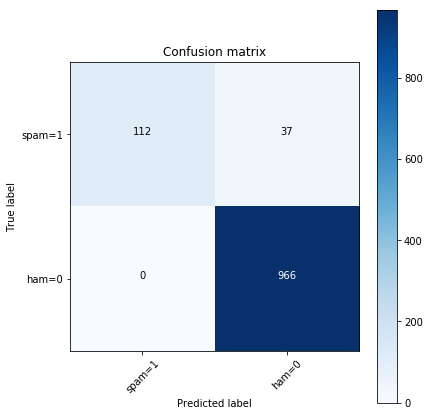

In [8]:
# Compute confusion matrix
cnf_matrix_LR = confusion_matrix(y_test, pred_LR, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_LR, classes=['spam=1','ham=0'],normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[116  33]
 [  1 965]]


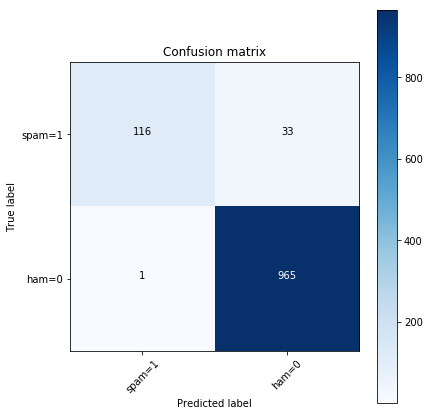

In [103]:
### Navie Bayes
from sklearn.naive_bayes import MultinomialNB
model_NB = MultinomialNB()
model_NB.fit(x_train,y_train)
pred_NB = model_NB.predict(x_test)

# Compute confusion matrix
cnf_matrix_NB = confusion_matrix(y_test, pred_NB, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_NB, classes=['spam=1','ham=0'],normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[  0 149]
 [  0 966]]


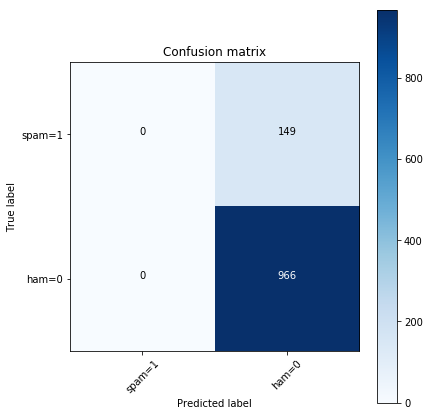

In [91]:
### Support Vector Machine
from sklearn.svm import SVC
model_SVC = SVC(C= 0.001,gamma='auto')
model_SVC.fit(x_train,y_train)

pred_SVC = model_SVC.predict(x_test)

# Compute confusion matrix
cnf_matrix_SVC = confusion_matrix(y_test, pred_SVC, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_SVC, classes=['spam=1','ham=0'],normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[118  31]
 [  0 966]]


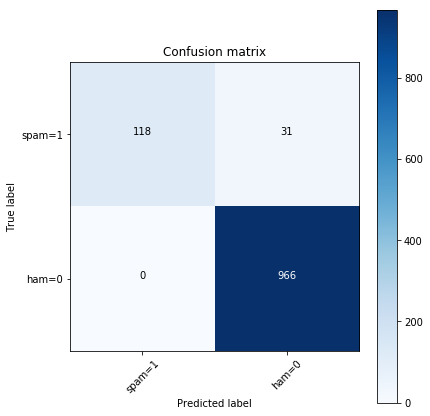

In [104]:
#### Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=10,max_depth=500)
model_RF.fit(x_train,y_train)

pred_RF = model_RF.predict(x_test)


# Compute confusion matrix
cnf_matrix_RF = confusion_matrix(y_test, pred_RF, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_RF, classes=['spam=1','ham=0'],normalize= False,  title='Confusion matrix')

In [105]:
### Comparing the models
print("The accuracy of Logistic Regression : {}".format(accuracy_score(y_test,pred_LR)))

print("The accuracy of Naive Bayes : {}".format(accuracy_score(y_test,pred_NB)))

print("The accuracy of SVM : {}".format(accuracy_score(y_test,pred_SVC)))

print("The accuracy of Random Forest : {}".format(accuracy_score(y_test,pred_RF)))

The accuracy of Logistic Regression : 0.9668161434977578
The accuracy of Naive Bayes : 0.9695067264573991
The accuracy of SVM : 0.8663677130044843
The accuracy of Random Forest : 0.9721973094170404


In [142]:
### Calculate Recall

print('The recall of Logistic Regression :{}'.format(recall_score(y_test,pred_LR)))
print('The recall of Naive Bayes :{}'.format(recall_score(y_test,pred_NB)))
print('The recall of SVM :{}'.format(recall_score(y_test,pred_SVC)))
print('The recall of Random Forest :{}'.format(recall_score(y_test,pred_RF)))

The recall of Logistic Regression :0.7516778523489933
The recall of Naive Bayes :0.7785234899328859
The recall of SVM :0.0
The recall of Random Forest :0.7919463087248322


In [140]:
### Calculate precicion 
print('The precision of Logistic Regression :{}'.format(precision_score(y_test,pred_LR)))
print('The precision of Naive Bayes :{}'.format(precision_score(y_test,pred_NB)))
print('The precision of SVM :{}'.format(precision_score(y_test,pred_SVC)))
print('The precision of Random Forest :{}'.format(precision_score(y_test,pred_RF)))

The precicion of Logistic Regression :1.0
The precicion of Naive Bayes :0.9914529914529915
The precicion of SVM :0.0
The precicion of Random Forest :1.0


In [146]:
### Calculate f1_score 
print('The f1_score of Logistic Regression :{}'.format(f1_score(y_test,pred_LR)))
print('The f1_score of Naive Bayes :{}'.format(f1_score(y_test,pred_NB)))
print('The f1_score of SVM :{}'.format(f1_score(y_test,pred_SVC)))
print('The f1_score of Random Forest :{}'.format(f1_score(y_test,pred_RF)))

The f1_score of Logistic Regression :0.8582375478927203
The f1_score of Naive Bayes :0.8721804511278196
The f1_score of SVM :0.0
The f1_score of Random Forest :0.8838951310861423


#####  By comparing the above models  we came to conclusion that Random Forest Classifier is most accurate followed by Naive Bayes  and Logistic Regression.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shivam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True